<h1><div class="alert alert-block alert-info">
 Neural Style Transfer
</div></h1>

This implementation is based on the Pytorch tutorial "https://pytorch.org/tutorials/advanced/neural_style_tutorial.html"

The idea is that given a content image and a style image we need to find a new image that:
- Matches the CNN features of the content image (feature reconstruction)
- Matches the Gram matrices of the style image (texture synthesis)

The combination of features with Neural Texture Synthesis from Gatys et al, using the same CNN!

<img src="https://miro.medium.com/max/1294/1*ZgW520SZr1QkGoFd3xqYMw.jpeg">

The architecture of the network:

<img src="https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/4c0301a45dc2e1e25bb4190e1fbb4fcd4ec5e1b4/3-Figure3-1.png">

The algorithm is:

- Pretrain CNN
- Compute features for content image
- Compute Gram matrices for style image
- Randomly initialize new image
- Loop until reach predefined ephocs 
    - Forward new image through CNN
    - Compute style loss (L2 distance between Gram matrices) and content loss (L2 distance between features)
    - Loss is weighted sum of style and content losses
    - Backprop to image
    - Take a gradient step

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn # Allows to create your own architecture
import torch.nn.functional as F # Preset types of layers that you can use in a neural network
import torch.optim as optim # Optimization algorithms

from PIL import Image # Python Imaging Library
import matplotlib.pyplot as plt

import torchvision.transforms as transforms # Common image transformations
import torchvision.models as models # Predifined models addressing different tasks

import copy

In [2]:
# If there is a GPU we prefer using it to process the algorithm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the Data

In [3]:
imsize = (512,512)

# Standardize the size of the imsize defined above
loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

# Send to the device that is going to process the image a tensor with
def image_loader(image_name):
    image = Image.open(image_name)
    # Unsqueeze returns a new tensor with a dimension of size one inserted at the specified position
    # Te loader transform the image in a tensor with the dimension (3, 512, 512)
    # After the unsqueeze we have a tensor representing with the dimension (1, 3, 512, 512)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [4]:
image_test = Image.open("./images/picasso.jpg")
print("Original image size: ", image_test.size)
# fake batch dimension required to fit network's input dimensions
image_without_squeeze = loader(image_test)
print("Image after transformation",image_without_squeeze.size())
image_squeezed = loader(image_test).unsqueeze(0)
print("After transformation we have 1 sample with 3 channels, with 512 rows and 512 columns")
print("Image after transformation and squeeze",image_squeezed.size())

Original image size:  (650, 650)
Image after transformation torch.Size([3, 512, 512])
After transformation we have 1 sample with 3 channels, with 512 rows and 512 columns
Image after transformation and squeeze torch.Size([1, 3, 512, 512])


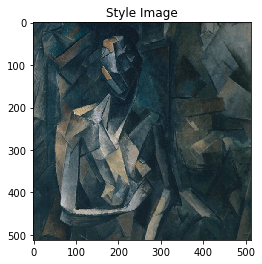

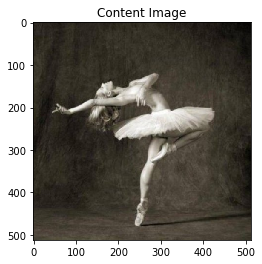

In [5]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the dimension added, returning to a tensor with (3, 512, 512)
    image = unloader(image)
    plt.imshow(image)
    plt.title(title)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

# Defining the loss functions and the optimizer

In [6]:
class ContentLoss(nn.Module): # The loss for the content picture

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input): # Calculation of the Gram matrices
    a, b, c, d = input.size()  # a=batch size(=1)
    # b = number of feature maps
    # (c,d) = dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module): # The loss for the style picture considers the Gram matrices

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [10]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    learning_rate = 1e-4
    #optimizer = optim.Adam([input_img.requires_grad_()], lr=learning_rate)
    return optimizer

# Defining the model

Our model that will be used to style transfer have the following archictecture:
    
NORMALIZATION > CONVOLUTION > RELU > CONVOLUTION > RELU > MAXPOOLING > CONVOLUTION > RELU > CONVOLUTION > RELU > MAXPOOLING > CONVOLUTION

In [11]:
# We get a pretrainned CNN
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [12]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
# desired depth layers to compute style/content losses:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    # We loop throught all the architecture of the VGG19 and copy it to our model, inheriting the training parameters 
    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # We get from the trained model the 
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # When we finish the loop will have 36 layers, but we need to reduce it to our architecture
    # so we start from the last element to the first to check the first ocurrence of the a loss function
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1): # range(start, stop, step)
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [14]:
model_tmp, style_losses_tmp, content_losses_tmp  = get_style_model_and_losses(cnn, cnn_normalization_mean, cnn_normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default)
model_tmp

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
)

# Running the model

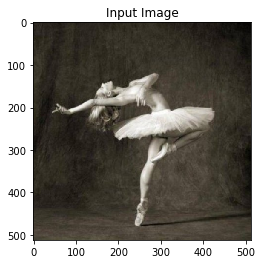

In [15]:
# As we want to apply the style in a give image we're going to start the model with the raw content picture
input_img = content_img.clone()

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [16]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1, debug = False):
    """Run the style transfer."""
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            
            if run[0] % 50 == 0 and debug == True :
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                plt.figure()
                imshow(input_img, title='Intermediate Image')
                # sphinx_gallery_thumbnail_number = 4
                #plt.ioff()
                plt.show()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


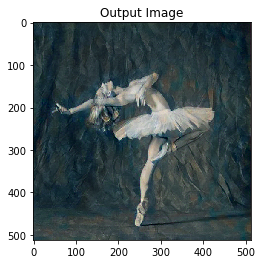

Wall time: 4min 15s


In [17]:
%%time
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [18]:
#!curl -o images\roman_routes.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcRIvZvdQloVanrSCAlxVbZAqueA6oBvhEgVuflsJf9U_E6JYT6c&usqp=CAU

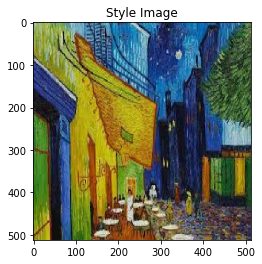

torch.Size([1, 3, 512, 512])


In [19]:
style_img = image_loader("./images/roman_routes.jpg")

plt.figure()
imshow(style_img, title='Style Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()
       
print(style_img.size())

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


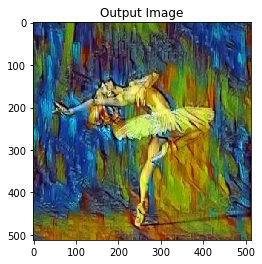

In [20]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()